###  Car Price Modeling Project

* Part 1 - Predict price with car metadata

* Part 2 - Predict price with metadata + image

* Details:  Get metadata from craigslist API.  Get additional relevant features, like gas price.  
  Clean data.  Put clean data in SQLite database.

### `Research Notes`

In [1]:
#KEY FEATURES
#price label, brand, model, age, horsepower/engine_type, mileage. time passage from ad post?

#SECONDARY FEATURES
#make, fuel type, mpg, exterior color, door number, transmission type,
#dimensions, safety, air condition, interior, navigation y/n, engine type
#cubic capacity, number of ad views, power steering, rim type
#registered city, number of doors, 4WD, damaged, leather, alarm,
#A/C, parking sensors, xenon lights, remote unlock, electric mirrors,
#seat heat, moon roof, cruise control, abs, traction control

#OTHER FEATURES
#estimated car life, price rank as category (cheap, moderate, expensive)

#Non-craigslist features
# gas price,

#Sparse features to ignore?: damaged, city

In [2]:
#FEATURE ENHANCEMENT:
#Train with stratified sample of make
#Encode Thumbs Up/Down fields: [ON, OFF, NotAvailable] -> [1, -1, 0]
#Poly features for regression.  Ex. Mileage and year
#Differencing features and explicit features for orest.

In [3]:
# Candidate models
# Regression, KNN, SVM, random forest, naive bayes, neural networks
# Neural network should be best, followed by RF and SVM.

In [4]:
# Frame as Price as Regression vs Classification Problem
# Classification: bin continuous features using cluster analysis?

###  Imports

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [6]:
%pwd

'C:\\Users\\Justin\\DATA_SCIENCE\\car_price_prediction'

In [7]:
#Import json
vehicle=pd.read_json('ford_vehicle.json')

In [8]:
#Remove whitespace
vehicle['SubLoc'] = vehicle['SubLoc'].str.strip()

#These autos are outside Houston.  Drop them.
vehicle[vehicle['SubLoc'] == '(TRUCKMAX)']
drop_indices = vehicle[vehicle['SubLoc'] == '(TRUCKMAX)'].index
print('Drop indices for TRUCKMAX:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop indices for TRUCKMAX: Int64Index([ 146,  158,  267,  375,  396,  436,  500,  752,  763,  771,  851,
             867,  877,  945,  962, 1069, 1093, 1230, 1279, 1325, 1327, 1354,
            1399, 1433, 1510, 1665, 1679, 1697, 1715, 1740, 1840, 1966, 1985,
            1989, 2020, 2031, 2040, 2080, 2215, 2304, 2343, 2359, 2409, 2422,
            2540, 2687, 2706, 2712, 2727, 2736, 2808, 2877, 2896, 2935],
           dtype='int64')


In [9]:
def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='error')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

In [10]:
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

def train_and_valid(what_model, num_folds, X, y):
    fold_rsme=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns

        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_rsme.append(round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 3))
    return fold_rsme, clone_model

In [11]:
#Add feature columns and view dataframe
print('vehicle length:', len(vehicle))
print('vehicle type:', type(vehicle))
vehicle.insert(2,'Year',np.nan)
vehicle.insert(3,'Year_in_Title',np.nan)
vehicle.insert(4,'Odometer',np.nan)
vehicle.insert(5,'RawMake',np.nan)
vehicle.insert(6,'Make',np.nan)
vehicle.insert(7,'Model',np.nan)
vehicle.insert(8,'Trim',np.nan)
vehicle.insert(10,'Seller',np.nan)
vehicle.head(3)

vehicle length: 2943
vehicle type: <class 'pandas.core.frame.DataFrame'>


,URL_Vehicle,Title,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Price,Seller,SubLoc,AttribDictionary,ImageDictionary
0,https://houston.craigslist.org/ctd/d/houston-2...,2013 FORD F-250 SD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$12950,NaN,(Hobby Area),{'0': '<span><b>2013 Ford F-250 SD</b></span>'...,{'0': 'https://images.craigslist.org/01414_au7...
1,https://houston.craigslist.org/cto/d/houston-2...,2013 Ford Expedition Limited,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$10800,NaN,None,{'0': '<span><b>2013 Ford Expedition</b></span...,{'0': 'https://images.craigslist.org/00r0r_2QE...
2,https://houston.craigslist.org/ctd/d/houston-1...,'11 Ford F150 FX4 SuperCrew🔥 AWD PickUp Truck❗...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$1000,NaN,"(In House Finance starting @ $1,000 DOWN! NO B...","{'0': '<span><b>2011 ford f-150</b></span>', '...",{'0': 'https://images.craigslist.org/00S0S_6sD...


In [12]:
vehicle.loc[0, 'AttribDictionary']

{'0': '<span><b>2013 Ford F-250 SD</b></span>',
 '1': '<span>VIN: <b>1FT7X2A68DEA99152</b></span>',
 '2': '<span>condition: <b>excellent</b></span>',
 '3': '<span>cylinders: <b>8 cylinders</b></span>',
 '4': '<span>fuel: <b>gas</b></span>',
 '5': '<span>odometer: <b>125142</b></span>',
 '6': '<span>paint color: <b>white</b></span>',
 '7': '<span>size: <b>full-size</b></span>',
 '8': '<span>title status: <b>clean</b></span>',
 '9': '<span>transmission: <b>automatic</b></span>',
 '10': '<span>type: <b>pickup</b></span>'}

In [13]:
#Extract any Odometer from AttribDictionary.
odomet=[]
for idx in vehicle.index:
    success_flag = 0    
    for k in vehicle.loc[idx, 'AttribDictionary'].keys():
        m = re.search('<span>odometer: <b>(\d+)', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
        
        if m is not None:
            success_flag = 1
            odomet.append(m.group(1))
            
    if success_flag != 1:
        odomet.append(np.nan)

vehicle['Odometer'] = odomet
vehicle['Odometer'] = vehicle['Odometer'].astype('float')

In [14]:
vehicle[vehicle['Odometer'] == vehicle['Odometer'].max()]
print(vehicle.loc[1472, 'URL_Vehicle'])

https://houston.craigslist.org/ctd/d/carrollton-2002-ford-150-harley/7004640894.html


In [15]:
#Create dealer/owner features using URL_vehicle.
vehicle['Seller']=vehicle['URL_Vehicle'].str.extract('(ct[o|d])')
vehicle['Seller']=vehicle['Seller'].str.replace('ctd', 'dealer')
vehicle['Seller']=vehicle['Seller'].str.replace('cto', 'owner')

In [16]:
#Build Year column from AttribDictionary.  Assert numeric format and none missing.
yrList=[]
for idx in vehicle.index:
    m = re.search('(\d+)', vehicle.loc[idx, 'AttribDictionary']['0'])  #re.search(pattern, string) gets first match
    yrList.append(m.group(1))  #group(1) returns first parenthesized subgroup
vehicle['Year'] = yrList    
vehicle['Year'] = vehicle['Year'].astype('float').astype('Int64')

#Keep Years 1999 and later.
filt = (vehicle['Year'] >= 1999)
vehicle = vehicle[filt]

assert vehicle['Year'].dtypes == 'Int64',  "Year must be a nullable integer."
assert len(vehicle[vehicle['Year'].isna()]) == 0, "Year cannot have NAs."

In [17]:
#Extract RawMake col from AttribDictionary.

rawMakeList=[]
for idx in vehicle.index:
    m = re.search('<b>(.+)</b>', vehicle.loc[idx, 'AttribDictionary']['0']) #re.search(pattern, string) gets first match
    if m is not None:
        rawMakeList.append(m.group(1).lower())
    else:
        print('Missing Make/Model index:', idx)
        rawMakeList.append('None')
                 
vehicle['RawMake'] = rawMakeList

In [18]:
#Extract Make col from RawMake col using regex pattern.

patt='\d*\s{0,2}\d+\s{1,2}(\w+)\s{0,2}(\w*-?[a-z]?)\s{0,2}(\w*-?[a-z]?)'

#Regex patter in verbose (re.X) format.
pattVerbose=re.compile(r'''\d*\s{0,2}         # 0 or more digits and 0-2 spaces
                           \d+\s{1,2}         # 1 or more digits and 1-2 spaces
                           (\w+)              # 1 or more words
                           \s{1,2}            # 1-2 whitespaces
                           (\w*-?[0-9|a-z]*)  # 0 or more words, 0 or 1 "-", 0 or more numbers/letters
                           \s{0,2}            # 0-2 whitespaces
                           (\w*-?[0-9|a-z]*)  # 0 or more words, 0 or 1 "-", 0 or more numbers/letters
                        ''', re.X)

makeList=[]
for idx in vehicle.index:
    m = re.search(pattVerbose, vehicle.loc[idx, 'RawMake']) #re.search(pattern, string) gets first match
    if m is not None:
        makeList.append([m.group(1).lower(), m.group(2).lower(), m.group(3).lower()])
    else:
        #print('Missing Make/Model index:', idx)
        makeList.append(['None', 'None', 'None'])
                 
vehicle['Make']=[item[0] for item in makeList]
vehicle['Model']=[item[1] for item in makeList]
vehicle['Trim']=[item[2] for item in makeList]

In [19]:
vehicle.head(5)

,URL_Vehicle,Title,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Price,Seller,SubLoc,AttribDictionary,ImageDictionary
0,https://houston.craigslist.org/ctd/d/houston-2...,2013 FORD F-250 SD,2013,NaN,125142.0,2013 ford f-250 sd,ford,f-250,sd,$12950,dealer,(Hobby Area),{'0': '<span><b>2013 Ford F-250 SD</b></span>'...,{'0': 'https://images.craigslist.org/01414_au7...
1,https://houston.craigslist.org/cto/d/houston-2...,2013 Ford Expedition Limited,2013,NaN,NaN,2013 ford expedition,ford,expedition,,$10800,owner,None,{'0': '<span><b>2013 Ford Expedition</b></span...,{'0': 'https://images.craigslist.org/00r0r_2QE...
2,https://houston.craigslist.org/ctd/d/houston-1...,'11 Ford F150 FX4 SuperCrew🔥 AWD PickUp Truck❗...,2011,NaN,127181.0,2011 ford f-150,ford,f-150,,$1000,dealer,"(In House Finance starting @ $1,000 DOWN! NO B...","{'0': '<span><b>2011 ford f-150</b></span>', '...",{'0': 'https://images.craigslist.org/00S0S_6sD...
3,https://houston.craigslist.org/ctd/d/houston-c...,CASH FOR YOUR JUNK CARS 📲346-775-0733 WE BUY/ ...,2003,NaN,NaN,2003 ford,None,None,None,$1000,dealer,(WE PAY BETTER THAN THE REST !!🌞🌞🌞),"{'0': '<span><b>2003 Ford</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00E0E_dU7...
4,https://houston.craigslist.org/ctd/d/houston-l...,Low Down $800! Bad Credit? 2011 Ford Expedition,2011,NaN,118000.0,2011 ford expedition,ford,expedition,,$800,dealer,(700 W 11th St),{'0': '<span><b>2011 ford expedition</b></span...,{'0': 'https://images.craigslist.org/00t0t_fmc...


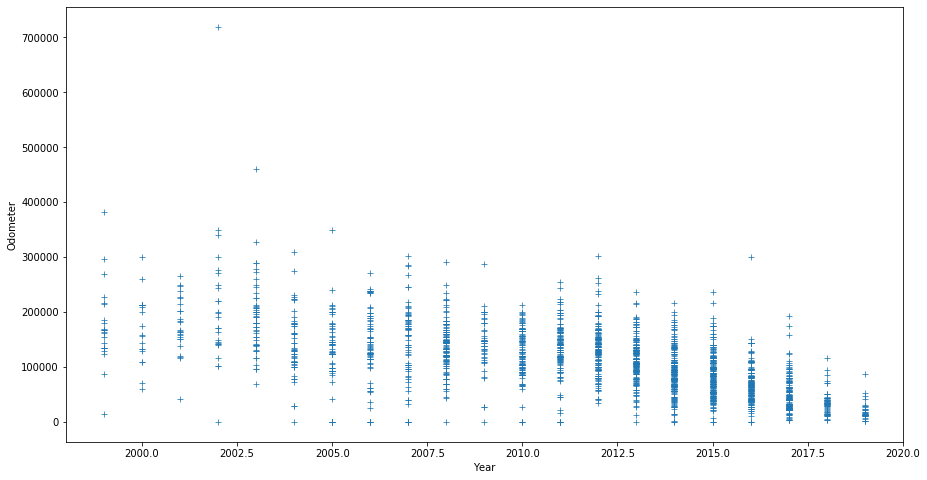

In [20]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='Year',y='Odometer', data=vehicle,  marker= '+')
plt.show()

In [21]:
#Drop Make = 'None'
filt = (vehicle['Make'] == 'None')
drop_indices = vehicle[filt].index
print('Drop Make is None rows:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop Make is None rows: Int64Index([   3,  103,  513,  526,  529,  646,  765,  824,  854,  898, 1037,
            1041, 1080, 1082, 1092, 1238, 1350, 1658, 1816, 1993, 2027, 2144,
            2270, 2369, 2848, 2899],
           dtype='int64')


In [22]:
#Scrub Price - remove any $, periods, and spaces.  Note:  ORDER IS IMPORTANT!!!
vehicle['Price']=vehicle['Price'].str.replace('\,', '')
vehicle['Price']=vehicle['Price'].str.replace('\.00', '')
vehicle['Price']=vehicle['Price'].str.replace('\.0', '')
vehicle['Price']=vehicle['Price'].str.replace('\$', '')
vehicle['Price']=vehicle['Price'].str.replace('-', '')
vehicle['Price']=vehicle['Price'].str.replace(' ', '')
vehicle['Price']=vehicle['Price'].str.replace('\.', 'None')

In [23]:
vehicle.head(2)

,URL_Vehicle,Title,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Price,Seller,SubLoc,AttribDictionary,ImageDictionary
0,https://houston.craigslist.org/ctd/d/houston-2...,2013 FORD F-250 SD,2013,NaN,125142.0,2013 ford f-250 sd,ford,f-250,sd,12950,dealer,(Hobby Area),{'0': '<span><b>2013 Ford F-250 SD</b></span>'...,{'0': 'https://images.craigslist.org/01414_au7...
1,https://houston.craigslist.org/cto/d/houston-2...,2013 Ford Expedition Limited,2013,NaN,NaN,2013 ford expedition,ford,expedition,,10800,owner,None,{'0': '<span><b>2013 Ford Expedition</b></span...,{'0': 'https://images.craigslist.org/00r0r_2QE...


In [24]:
#Price is missing, None, or blank.  Drop corresponding rows.
filt = (vehicle['Price'].isna()) | (vehicle['Price'] == 'None') | (vehicle['Price'] == '')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} missing price rows:', drop_indices, '\n')
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Make isn't 'ford'.  Drop corresponding rows.
filt = (vehicle['Make'] != 'ford')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} non-ford makes:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Cast Price as float.
vehicle['Price'] = vehicle['Price'].astype('float')
assert len(vehicle[vehicle['Price'].isna()]) == 0, "Price cannot have NAs."

Drop 308 missing price rows: Int64Index([  17,   18,   19,   22,   33,   34,   46,   47,   48,   55,
            ...
            2947, 2948, 2953, 2970, 2977, 2988, 2990, 2991, 2993, 2995],
           dtype='int64', length=308) 

Drop 3 non-ford makes: Int64Index([163, 1102, 2720], dtype='int64')


In [25]:
#Fix Model spelling
model_dict={
            'Model': {np.nan : 'None', 
                      '' : 'None',
                      'f150' : 'f-150',
                      'f250' : 'f-250', 
                      'f350' : 'f-350', 
                      'f450' : 'f-450'}
            }

vehicle.replace(model_dict, inplace=True)

#Remove vehicle 'Model' counts under 50.  Save to dataframe veh.
model_counts=vehicle['Model'].value_counts()             #get model freq
models_over_50 = model_counts[model_counts >= 50].index  #get 50+ model names
veh = vehicle[vehicle['Model'].isin(models_over_50)].copy() #boolean filter for the 50+ model names
veh['Model'].value_counts()

f-150         730
f-250         235
mustang       192
expedition    142
fusion        124
explorer      119
f-350         116
transit       104
escape        101
focus          96
edge           84
super          73
Name: Model, dtype: int64

In [26]:
#Drop prices under $100 or over $60,000
drop_indices=veh[(veh['Price'] < 100) | (veh['Price'] > 60000)].index

print(f'Drop {len(drop_indices)} prices ouside $100 - $60,000:', drop_indices)
veh.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 22 prices ouside $100 - $60,000: Int64Index([  71,  140,  331,  420,  426,  629, 1113, 1344, 1349, 1395, 1534,
            1535, 1634, 1726, 2124, 2283, 2340, 2659, 2764, 2778, 2785, 2833],
           dtype='int64')


In [27]:
def flag_outliers(df, filt_col, filt_col_val, col_to_flag):
    ''' Flag anomolies for target col_to_flag and filt_col_val.'''
    filtSer=df.loc[df[filt_col] == filt_col_val, col_to_flag].copy()
    three_std = 3 * filtSer.std()
    avg = filtSer.mean()
    lower_lim = avg - three_std
    upper_lim = avg + three_std
    print(' average:', round(avg,1), '\n', 'lower_lim:', round(lower_lim,1), '\n', 'upper_lim:', round(upper_lim,1))
    
    outside_lim=[]
    for idx in filtSer.index:      
        price = filtSer.loc[idx]        
        if price > upper_lim or price < lower_lim:
            outside_lim.append([idx, col_to_flag, price])     
    return outside_lim

outs_lim = flag_outliers(df=veh, filt_col='Year', filt_col_val=2002, col_to_flag='Odometer')               
display(outs_lim)

 average: 246676.0 
 lower_lim: -208373.6 
 upper_lim: 701725.6


[[1472, 'Odometer', 719364.0]]

In [28]:
pd.set_option('max_colwidth', 100)
veh.loc[1472]

URL_Vehicle                        https://houston.craigslist.org/ctd/d/carrollton-2002-ford-150-harley/7004640894.html
Title                                                                2002 *Ford* *F-150* *Harley* Davidson Supercharged
Year                                                                                                               2002
Year_in_Title                                                                                                       NaN
Odometer                                                                                                         719364
RawMake                                                                                                 2002 ford f-150
Make                                                                                                               ford
Model                                                                                                             f-150
Trim                                    

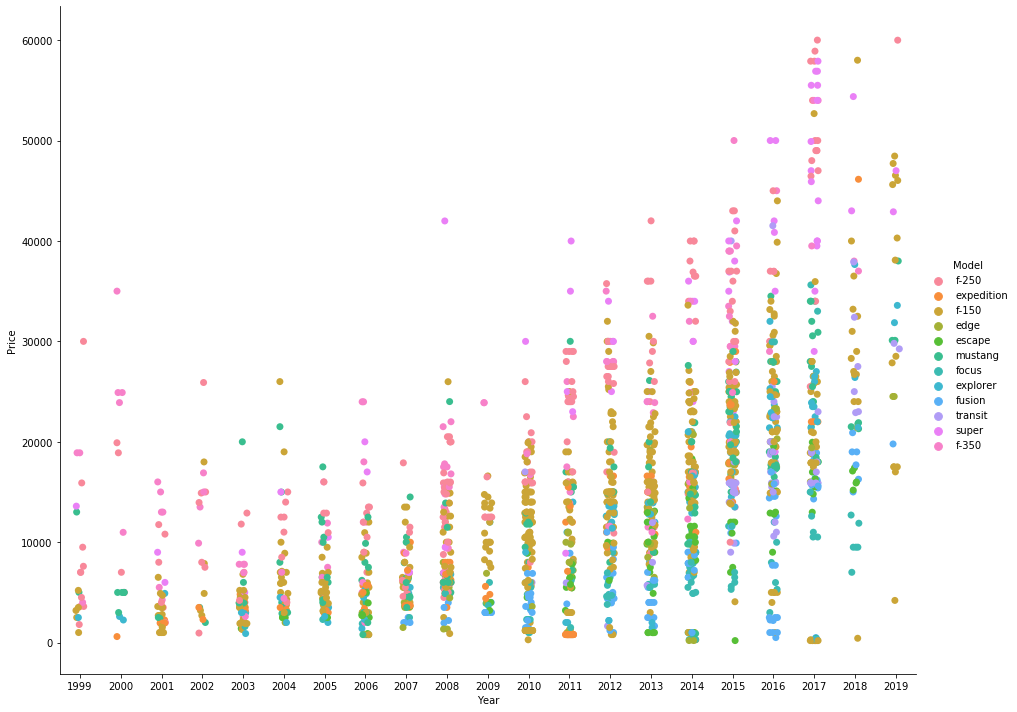

In [29]:
#Catplot by Year, Price, and Model
sns.catplot(x='Year',y='Price',hue='Model', data=veh, height=10, aspect=1.3, s=7)  #s changes marker size
plt.show()

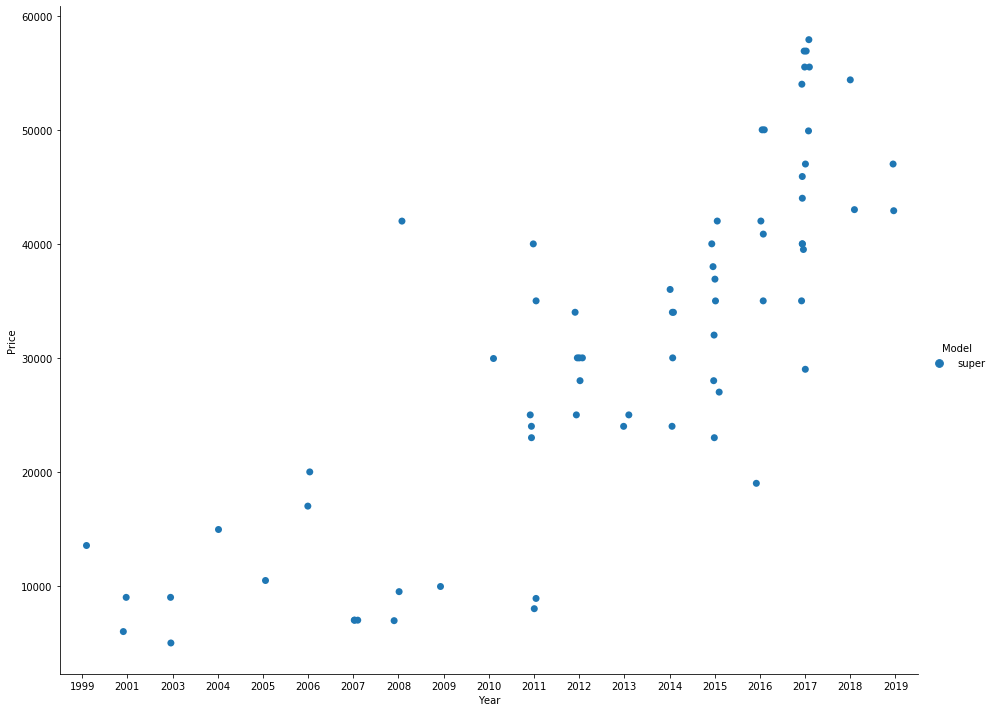

In [30]:
#Catplot by Year, Price, and Selected Model
sns.catplot(x='Year',y='Price',hue='Model', data=veh[veh['Model']=='super'], height=10, aspect=1.3, s=7)  #s changes marker size
plt.show()

In [31]:
veh[(veh['Model'] == 'f-250') & (veh['Year'] == 1999)].sort_values(by='Price', ascending=False)[0:3]

,URL_Vehicle,Title,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Price,Seller,SubLoc,AttribDictionary,ImageDictionary
822,https://houston.craigslist.org/ctd/d/houston-1999-ford-250-f-xlt-73l/7004413604.html,1999 Ford F-250 F250 F 250 XLT 7.3L Powerstroke Diesel 14K miles,1999,NaN,14380.0,1999 ford f-250 f250 f 250,ford,f-250,f250,29995.0,dealer,(Diesel of Houston),"{'0': '<span><b>1999 Ford F-250 F250 F 250</b></span>', '1': '<span>VIN: <b>1FTNX21F8XEF04714</b...","{'0': 'https://images.craigslist.org/00m0m_aaRdepaNGvU_600x450.jpg', '1': 'https://images.craigs..."
2442,https://houston.craigslist.org/ctd/d/houston-1999-ford-250-excab-lb-73l/7010994265.html,1999 Ford F-250 ExCab LB 7.3L Diesel 6-SP Manual 4x4 XLT 2Owner Stock!,1999,NaN,185597.0,1999 ford f-250,ford,f-250,,15900.0,dealer,(RBP AUTOMOTIVE INC),"{'0': '<span><b>1999 Ford F-250</b></span>', '1': '<span>condition: <b>excellent</b></span>', '2...","{'0': 'https://images.craigslist.org/00u0u_96ofRBIzQPp_600x450.jpg', '1': 'https://images.craigs..."
1603,https://houston.craigslist.org/cto/d/wharton-f250-4-door-long-bed-diesel/7005642380.html,1999.5 F250 4 Door Long Bed DIESEL,1999,NaN,297000.0,1999 ford f250 super duty,ford,f-250,super,9500.0,owner,(Wharton),"{'0': '<span><b>1999 ford f250 super duty</b></span>', '1': '<span>condition: <b>good</b></span>...","{'0': 'https://images.craigslist.org/00s0s_cVj44c3lVYL_600x450.jpg', '1': 'https://images.craigs..."


In [32]:
#Reset veh dataframe indices.
#veh.reset_index(drop=True, inplace=True)

In [33]:
#Build train and test from veh.  Stratify by Model.
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=22)
for train_index, test_index in sss.split(veh, veh['Model']):
    train = veh.iloc[train_index]
    test = veh.iloc[test_index]

In [34]:
#Drop features
train = train.drop(['URL_Vehicle', 'Title', 'Year_in_Title', 'LN_Price', 'SubLoc', 'AttribDictionary', 'ImageDictionary', 'RawMake'],
           axis='columns', errors='ignore')

test = test.drop(['URL_Vehicle', 'Title', 'Year_in_Title', 'LN_Price', 'SubLoc', 'AttribDictionary', 'ImageDictionary', 'RawMake'],
           axis='columns', errors='ignore')

In [35]:
def impute_nan_by_categ(train_df, test_df, cat_col1, cat_col2, stat_col, stat_calc = 'median'):
    ''' Using train, get dictionary entry for each cat_col 1-2 group:
        {'group': {'stat_col': value}}.  Replace nan with train value in 
        both train and test.  This avoids data leakage.  Return  updated
        train and test dataframes.'''
    
    trn = train_df.copy()
    tst = test_df.copy()
    trnDict=trn.groupby([cat_col1, cat_col2]).agg({stat_col : stat_calc}).to_dict('index')
    trnDict_fallback=trn.groupby([cat_col1]).agg({stat_col : stat_calc}).to_dict('index')
    print(f'Made dictionary of {stat_calc} {stat_col} value by {cat_col1}-{cat_col2}. Fallback by {cat_col1}.')
        
    for k in trnDict.keys():  #scrub by Model-Year
        filtTrain = (trn[cat_col1] == k[0]) & (trn[cat_col2] == k[1]) & (trn[stat_col].isna())
        filtTest = (tst[cat_col1] == k[0]) & (tst[cat_col1] == k[1]) & (tst[stat_col].isna())
        val = trnDict[k][stat_col]        
        fallback_val = trnDict_fallback[k[0]][stat_col]
        
        if np.isnan(val):
            trn.loc[filtTrain, stat_col] = fallback_val
            tst.loc[filtTest, stat_col] = fallback_val
        else:
            trn.loc[filtTrain, stat_col] = val
            tst.loc[filtTest, stat_col] = val            
            
    for key in trnDict_fallback.keys():    #scrub the missed Model-Year combos in test with Model-only fallback.
        filtTestCatCol1 = (tst[cat_col1] == key) & (tst[stat_col].isna())
        catCol1_val = trnDict_fallback[key][stat_col]
        tst.loc[filtTestCatCol1, stat_col] = catCol1_val
        
    return trn, tst, trnDict, trnDict_fallback

#Update NaNs with median odometer value by Model-Year.
train, test, trnDict, trnDict_fallback = impute_nan_by_categ(train_df=train, test_df=test, cat_col1='Model', cat_col2='Year', stat_col='Odometer')  

Made dictionary of median Odometer value by Model-Year. Fallback by Model.


In [36]:
#Get One-Hot columns for the specified categ_columns.
categ_cols= ['Year', 'Make', 'Model', 'Trim', 'Seller']
ohe_train_df, ohe_test_df = one_hot_encode(train_df=train, test_df=test, cat_cols=categ_cols)

In [37]:
#Drop original category columns.  Insert the One-Hot category columns.
train = train.drop(columns=categ_cols, axis='columns', errors='ignore')
test = test.drop(columns=categ_cols, axis='columns', errors='ignore')

train = pd.concat([train, ohe_train_df], axis='columns')
test = pd.concat([test, ohe_test_df], axis='columns')
display('train:', train.head(2))
display('test:', test.head(2))

'train:'

,Odometer,Price,Year_1999,Year_2000,Year_2001,Year_2002,Year_2003,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Make_ford,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_focus,Model_fusion,Model_mustang,Model_super,Model_transit,Trim_,Trim_1-owner,Trim_150,Trim_2013,Trim_2015,Trim_2016,Trim_250,Trim_2wd,Trim_4dr,Trim_4wd,Trim_4x4,Trim_6,Trim_base,Trim_bucket,Trim_bullitt,Trim_cargo,Trim_cobra,Trim_connect,Trim_convertible,Trim_coupe,Trim_crew,Trim_crewcab,Trim_diesel,Trim_duty,Trim_ecoboost,Trim_eddie,Trim_el,Trim_extended,Trim_f250,Trim_f350,Trim_flatbed,Trim_fx2,Trim_fx4,Trim_gt,Trim_harley,Trim_harley-davidson,Trim_hybrid,Trim_king,Trim_kingranch4x4crewdiesel,Trim_lariat,Trim_limited,Trim_ltd,Trim_passenger,Trim_pickup,Trim_platinum,Trim_powerstroke,Trim_premium,Trim_raptor,Trim_regular,Trim_rs,Trim_s,Trim_saleen,Trim_sd,Trim_se,Trim_sel,Trim_ses,Trim_sh,Trim_sport,Trim_st,Trim_stx,Trim_super,Trim_supercrew,Trim_superduty,Trim_svt,Trim_sxt,Trim_súper,Trim_t-250,Trim_t-350,Trim_titanium,Trim_v6,Trim_van,Trim_wagon,Trim_x,Trim_xl,Trim_xls,Trim_xlt,Seller_dealer,Seller_owner
2355,88101.0,7995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1361,133269.0,7995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


'test:'

,Odometer,Price,Year_1999,Year_2000,Year_2001,Year_2002,Year_2003,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Make_ford,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_focus,Model_fusion,Model_mustang,Model_super,Model_transit,Trim_,Trim_1-owner,Trim_150,Trim_2013,Trim_2015,Trim_2016,Trim_250,Trim_2wd,Trim_4dr,Trim_4wd,Trim_4x4,Trim_6,Trim_base,Trim_bucket,Trim_bullitt,Trim_cargo,Trim_cobra,Trim_connect,Trim_convertible,Trim_coupe,Trim_crew,Trim_crewcab,Trim_diesel,Trim_duty,Trim_ecoboost,Trim_eddie,Trim_el,Trim_extended,Trim_f250,Trim_f350,Trim_flatbed,Trim_fx2,Trim_fx4,Trim_gt,Trim_harley,Trim_harley-davidson,Trim_hybrid,Trim_king,Trim_kingranch4x4crewdiesel,Trim_lariat,Trim_limited,Trim_ltd,Trim_passenger,Trim_pickup,Trim_platinum,Trim_powerstroke,Trim_premium,Trim_raptor,Trim_regular,Trim_rs,Trim_s,Trim_saleen,Trim_sd,Trim_se,Trim_sel,Trim_ses,Trim_sh,Trim_sport,Trim_st,Trim_stx,Trim_super,Trim_supercrew,Trim_superduty,Trim_svt,Trim_sxt,Trim_súper,Trim_t-250,Trim_t-350,Trim_titanium,Trim_v6,Trim_van,Trim_wagon,Trim_x,Trim_xl,Trim_xls,Trim_xlt,Seller_dealer,Seller_owner
69,138030.0,33991.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2164,172400.0,7500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
#Create trainX, trainY, testX, and testY
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

In [39]:
# #Review noise features - where one category is nearly all observations.

# noise_feat = []
# pct_zeros = .999
# for i in trainX.columns:
#     counts = trainX[i].value_counts()
#     zeros = counts.iloc[0]  #top frequency category    
#     if zeros / len(trainX) > pct_zeros:
#         noise_feat.append(i)

# print(f'### {len(noise_feat)} Noise Features at {pct_zeros} pct zeros cutoff:  ###')
# print(f'### Noise Features: {noise_feat}  ###\n')

# for c in trainX.columns:
#     counts = trainX[c].value_counts()
#     zeros = counts.iloc[0]  #top frequency category
#     print('Count nonzero -', (len(trainX[c]) - zeros),':')
#     plt.figure(figsize=[4,4])
#     plt.scatter(trainX[c], trainY)
#     plt.title(f'{c} vs Price'); plt.xlabel(f'{c}'); plt.ylabel('Price');
#     plt.show()

# #Drop noise features.  Will help non-regularized models by reducing dimensionality.
# trainX = trainX.drop(columns=noise_feat, axis='columns', errors='ignore')
# testX = testX.drop(columns=noise_feat, axis='columns', errors='ignore')

## `Tune Models with Cross Validation`

In [40]:
#Train and Score LR CV
lr=LinearRegression(fit_intercept=False)
fold_rsme, linMod = train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## LR R^2:', round(linMod.score(trainX, trainY),3))

Fold RSME: [6436.673, 5469.729, 4864.795, 6659.057, 5305.707, 6908.632, 6139.774, 7025.789, 5988.346, 6188.16]
## Avg RMSE: 6098.6662 +- 671.7545
## LR R^2: 0.703


In [41]:
#Train and Score Ridge CV
ridge=Ridge(alpha=.1, solver='cholesky')
fold_rsme, ridgeMod = train_and_valid(what_model=ridge, num_folds=10, X=trainX, y=trainY)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## ridge R^2:', round(ridgeMod.score(trainX, trainY),3))

Fold RSME: [6416.671, 5467.844, 4862.057, 6636.733, 5296.561, 6910.223, 6143.42, 7022.943, 5971.358, 6193.642]
## Avg RMSE: 6092.1452 +- 670.8854
## ridge R^2: 0.702


## `Predict`

In [42]:
linregr=LinearRegression(fit_intercept=False)  #no scaling required for closed-form solution
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_linregr)), 4)
print('test RMSE:', RMSE)
print('test R^2 test:', round(linregr.score(testX, testY),4))

test RMSE: 6282.8511
test R^2 test: 0.681


In [43]:
rr=Ridge(alpha=.1, solver='cholesky')  #no scaling required for closed-form solution
rr.fit(trainX, trainY)
y_pred_rr=rr.predict(testX)
RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_rr)), 4)
print('test RMSE:', RMSE)
print('test R^2:', round(rr.score(testX, testY),4))

test RMSE: 6283.2723
test R^2: 0.681


### *Need more data to improve predictions!*

* Pick for sale by all (owner or dealer) rather than just owner.  DONE.
* Combine Houston with College Station and Galveston?
* Pick more common manufacturer.  DONE.
* Using Natural Log price.  DONE -- DOES **NOT** HELP

In [44]:
#Existing data is Honda for sale by Owner
print('train (rows,cols):', trainX.shape)
print('test (rows,cols):', testX.shape)

train (rows,cols): (1675, 113)
test (rows,cols): (419, 113)


In [45]:
#*********************************UNUSED CODE**************************************

# #Extract Year_in_Title from vehicle Title and save off column - pandas.Series.str.extract

# patt='(\d+)'
# vehicle['Year_in_Title'] = vehicle['Title'].str.extract(patt).replace(np.nan, 'None')

# def fix_2digit(row):
#     if len(row) == 4 or row == 'None':
#         return row
#     elif row in [str(dig).zfill(2) for dig in range(0,21)]:    #Assume 00 - 20 is 2000s
#         return '20' + row
#     elif row in [str(dig).zfill(2) for dig in range(21,100)]:  #Assume 21 - 99 is 1900s
#         return '19' + row
#     else:
#         return 'None'
    
# vehicle['Year_in_Title'] = vehicle['Year_in_Title'].apply(fix_2digit)
# vehicle['Year_in_Title'] = vehicle['Year_in_Title'].replace('None',np.nan).astype('float').astype('Int64')
# vehicle['Year_in_Title'].value_counts(dropna=False)

#re.search('<b>(\d*\s{0,2})(\d+\s{1,2}\w+\s{1,2}\w+\s{0,2}\w*)</b>', vehicle.loc[55, 'AttribDictionary']['0']).group(0)

In [46]:
# from scipy import stats
# from scipy.stats import norm

# def normalize_feature(df, bad_feature):
    
#     #Make histogram & normal probability plot
#     fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
#     sns.distplot(df[bad_feature], color='r', fit=stats.norm, ax=ax1)
#     ax1.set_title(f'{bad_feature} Histogram - Not Normal Distribution')
#     res=stats.probplot(df[bad_feature], dist='norm', plot=ax2)
#     ax2.set_title('Fit to Normal Distribution')

#     #Normalize with log (x+1).  Log of skewed feature: log e(feature+1)=normFeat
#     #Exponential equation to undo normpr: e^normFeat-1=feature
#     log_feat=np.log(df[bad_feature]+1)
        
#     #Plots after normalization
#     fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
#     sns.distplot(log_feat, color='g', fit=norm, ax=ax1)
#     ax1.set_title(bad_feature+' Histogram - Normal Distribution')
#     res=stats.probplot(log_feat, dist='norm', plot=ax2)
#     ax2.set_title('Fit to Normal Distribution')
#     return log_feat

# vehicle['LN_Price'] = normalize_feature(df=vehicle, bad_feature='Price')
# print('**** No Fit improvement from LN transform of price. ****')

In [47]:
# def impute_nan_by_categ(train_df, test_df, cat_col, stat_col, stat_calc = 'median'):
#     ''' Using train, get dictionary entry for each category in cat_col:
#         {'cat_1': {'stat_col': value}}.  Replace nan with train value in 
#         both train and test.  This avoids data leakage.  Return  updated
#         train and test dataframes.'''
    
#     trn = train_df.copy()
#     tst = test_df.copy()
#     trnDict=trn.groupby([cat_col]).agg({stat_col : stat_calc}).to_dict('index')
#     print(f'train dictionary for the NaNs - {stat_calc} {stat_col} value by {cat_col}.')
#     display(trnDict)
    
#     for k in trnDict.keys():
#         filtTrain = (trn[cat_col] == k) & (trn[stat_col].isna())
#         filtTest = (tst[cat_col] == k) & (tst[stat_col].isna())
#         val = trnDict[k][stat_col]
#         trn.loc[filtTrain, stat_col] = val  #assign value to any NaNs for category
#         tst.loc[filtTest, stat_col] = val
#     return trn, tst

# #run impute function
# train, test = impute_nan_by_categ(train_df=train, test_df=test, cat_col='Model', stat_col='Odometer')  

In [48]:
# #Scale Odometer values in train and test.  Note NO SCALING NEEDED for closed-form solutions.

# def scale_num_df(train_df, test_df, numer_cols, scaler):
#     #fit_transform train
#     scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
#     scaled_trn_num_df.index=train_df.index
#     scaled_trn_num_df.columns=train_df[numer_cols].columns
#     display(scaled_trn_num_df.tail(2))

#     #transform test
#     scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
#     scaled_tst_num_df.index=test_df.index
#     scaled_tst_num_df.columns=test_df[numer_cols].columns
#     display(scaled_tst_num_df.head(2))
#     return scaled_trn_num_df, scaled_tst_num_df

# odTrn, odTst = scale_num_df(train_df=train, test_df=test, numer_cols=['Odometer'], scaler=MinMaxScaler(feature_range=(0,2)))
# train['Odometer'] = odTrn
# test['Odometer'] = odTst